**1. 라이브러리 임포트**

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

**2. 하이퍼파라미터 셋팅**

In [2]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2

num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**3. MNIST train, test dataset 가져오기**

In [4]:
# MNIST dataset
mnist_train = dset.MNIST("", train = True, transform = transforms.ToTensor(),
                         target_transform = None, download = True) # train 용으로 쓰겠다.
mnist_test = dset.MNIST("", train = False, transform = transforms.ToTensor(),
                        target_transform = None, download = True) # test 용으로 쓰겠다.


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw




Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**4. 대략적인 데이터 형태**

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label: 5


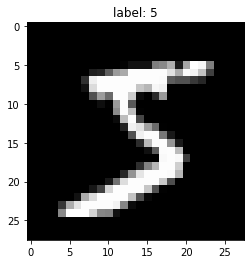

In [5]:
print("mnist_train 길이:", len(mnist_train))
print("mnist_test 길이:", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print("image data 형태:", image.size())
print("label:", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환 (1, 28, 28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap = 'gray')
plt.show()

**5. 데이터 로드 함수**

In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset = mnist_train, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           drop_last = True) # mnist_train을 학습 시키자. # batch_size 만큼 나눌 때 나머지는 버려라.
test_loader = torch.utils.data.DataLoader(dataset = mnist_test, 
                                          batch_size = batch_size, 
                                          shuffle = False, 
                                          drop_last = True) # test에서는 shuffle 하지 않음

**6. 데이터 로드 함수 이해하기**

[0]
한 번에 로드되는 데이터 크기: 100


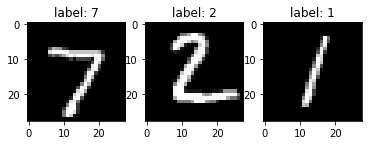

[1]
한 번에 로드되는 데이터 크기: 100


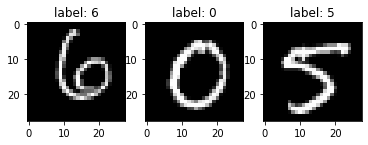

[2]
한 번에 로드되는 데이터 크기: 100


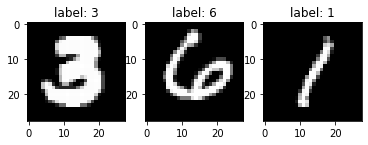

[3]
한 번에 로드되는 데이터 크기: 100


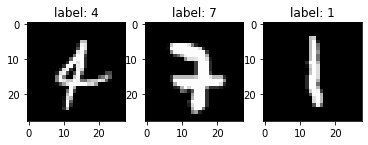

[4]
한 번에 로드되는 데이터 크기: 100


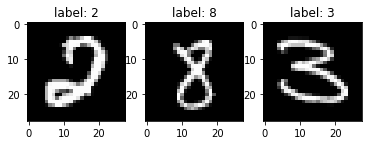

[5]
한 번에 로드되는 데이터 크기: 100


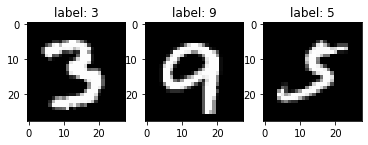

In [7]:
n = 3 # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader): 
  if i > 5:
    break # batch_size 만큼
  
  print("[%d]" %i)
  print("한 번에 로드되는 데이터 크기:", len(imgs))

  # 그리기
  for j in range(n):
    img = imgs[j].numpy() # image 타입을 numpy로 변환 (1, 28, 28)
    img = img.reshape((img.shape[1], img.shape[2])) # (1, 28, 28) -> (28, 28)
    # print img.shape

    plt.subplot(1, n, j+1) # (1, 3) 형태 플랏의 j번째 자리에 그리겠다.
    plt.imshow(img, cmap = 'gray')
    plt.title("label: %d" %labels[j])
  plt.show()

**7. 모델 선언**

In [8]:
# Recurrent Neural Network (many-to-one)
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # ------
    # input tensor: (batch_size, seq_length, input_size)
    # x: (100, 28, 28)
    # print('x:', x.shape)

    # ------
    # hidden state tensor: (# of layers, batch_size, hidden_size)
    # h: (2, 100, 128)
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    # ------
    # Forward propagate LSTM
    # output tensor: (batch_size, seq_length, hidden_size)
    # out: (100, 28, 128)
    # print('out:', out.shape)

    out, _ = self.lstm(x, (h0, c0))

    # ------
    # 28번째 output layer: (bs, hidden_size)
    # out[:, -1, :]: (100, 128)
    # print('out[-1]:', out[:, -1, :].shape)

    # ------
    out = self.fc(out[:, -1, :])

    # y^: (batch_size, num_classes)
    # y_pred: (100, 10)
    # print('out:', out.shape)

    return out

In [9]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)